In [80]:
import os
import shutil
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import trange
from torchvision.transforms import Grayscale
import matplotlib.pyplot as plt


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 567
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)


#"/Users/quentin/Desktop/ML_MRIqc_DATASET/Ready_Data"
data_transforms = {
    "train": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),  # Resize images to VGG16-compatible dimensions (just to keep it consistent with the future)
        transforms.RandomHorizontalFlip(),  # Augmentation
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize([0.5], [0.5])  # Normalize grayscale images
    ]),
    "val": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    "test": transforms.Compose([
        Grayscale(num_output_channels=1),  # Convert images to grayscale
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

data_dir = "/Users/quentin/Desktop/ML_MRIqc_DATASET/Ready_Data"
datasets = {
    x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}
dataloaders = {
    x: DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4) # Try smaller batch sizes [8,16]
    for x in ["train", "val", "test"]
}

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

### Create AutoEncoder model
class AE(torch.nn.Module):
    def __init__(self, latent_dim=128):
        super(AE, self).__init__()
        # To do this we need to shrink the input from 224 x 224 > ? > ? > ... > 18 > 9 
        # self.encoder = torch.nn.Sequential(
        #     nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 224x224 -> 112x112
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 112x112 -> 56x56
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 56x56 -> 28x28
        #     nn.ReLU(),
        #     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
        #     nn.ReLU(),
        #     nn.Flatten(),  # Flatten into 1D (from 256x14x14 to a single vector)
        #     nn.Linear(256 * 14 * 14, latent_dim)  # Latent space compression
        # )
        
        # self.classifier = nn.Linear(latent_dim, 2)

        self.encoder = torch.nn.Sequential(
            # Add BatchNorm and potentially adjust kernel sizes/strides
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, latent_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x, classify=False):
        encoded = self.encoder(x)
        return self.classifier(encoded)
        
        # Then we need to decode it going from 9 > 18 > ... ? > 224 x 224
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, 256 * 14 * 14),  # Expand from latent space
        #     nn.Unflatten(1, (256, 14, 14)),  # Unflatten to 256x14x14
        #     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=1)
        # )
 
    # def forward(self, x):
    #     encoded = self.encoder(x)
    #     # decoded = self.decoder(encoded)
    #     return decoded

# Try AdaGrad optimizer with normal x-entropy loss
model = AE(latent_dim = 128).to(DEVICE)
optimizer = optim.Adagrad(model.parameters(), lr=0.00001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride

In [67]:
# Train and Test functions
def train_one_epoch(loader, model, device, optimizer, criterion, log_interval, epoch):
    model.train()
    total_loss = 0
    correct = 0
    losses = []
    counter = []

    for i, (img, label) in enumerate(loader):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
        
        if (i + 1) % log_interval == 0:
            losses.append(loss.item())
            counter.append((i * loader.batch_size) + len(img) + epoch * len(loader.dataset))

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)

    return avg_loss, accuracy, losses, counter

def evaluate(loader, model, device, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for img, label in loader:
            img, label = img.to(device), label.to(device)
            output = model(img)
            loss = criterion(output, label)
            total_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=False)
            correct += pred.eq(label).sum().item()

            predictions.extend(pred.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy, predictions, true_labels


In [82]:
# train loop
max_epochs = 20
patience = 2 # Early stopping (i.e. loss doesn't improve for patience # of epochs)
best_val_loss = float('inf')
p_counter = 0
log_interval = 7

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
log_losses = []
log_counter = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    # Train
    train_loss, train_accuracy, train_log_loss, train_log_counter = train_one_epoch(train_loader, model, DEVICE, optimizer, criterion, log_interval, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    log_losses.extend(train_log_loss)  # log losses
    log_counter.extend(train_log_counter)  # log counters

    # Validate
    val_loss, val_accuracy,val_pred, val_labels = evaluate(val_loader, model, DEVICE, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model_AE.pth")  # Save the best model
        p_counter = 0  # Reset patience counter
    else:
        p_counter += 1
        if p_counter >= patience:
            print(f"Early stopping triggered! TOTAL EPOCHS = {epoch}")
            break

Epochs:   5%|█▋                               | 1/20 [03:09<1:00:01, 189.56s/it]

Epoch 1:
Train Loss: 0.7005, Train Accuracy: 0.5633
Val Loss: 0.6835, Val Accuracy: 0.5935


Epochs:  10%|███▌                               | 2/20 [06:28<58:31, 195.07s/it]

Epoch 2:
Train Loss: 0.6516, Train Accuracy: 0.6119
Val Loss: 0.6770, Val Accuracy: 0.5971


Epochs:  15%|█████▎                             | 3/20 [09:58<57:10, 201.78s/it]

Epoch 3:
Train Loss: 0.6349, Train Accuracy: 0.6375
Val Loss: 0.6758, Val Accuracy: 0.6223


Epochs:  20%|███████                            | 4/20 [13:13<53:05, 199.09s/it]

Epoch 4:
Train Loss: 0.6284, Train Accuracy: 0.6379
Val Loss: 0.6755, Val Accuracy: 0.5683


Epochs:  25%|████████▊                          | 5/20 [16:35<50:02, 200.15s/it]

Epoch 5:
Train Loss: 0.6136, Train Accuracy: 0.6608
Val Loss: 0.6711, Val Accuracy: 0.5683


Epochs:  30%|██████████▌                        | 6/20 [20:23<48:54, 209.59s/it]

Epoch 6:
Train Loss: 0.6094, Train Accuracy: 0.6622
Val Loss: 0.6647, Val Accuracy: 0.7158


Epochs:  35%|████████████▎                      | 7/20 [23:37<44:20, 204.66s/it]

Epoch 7:
Train Loss: 0.5993, Train Accuracy: 0.6932
Val Loss: 0.6683, Val Accuracy: 0.6079


Epochs:  40%|██████████████                     | 8/20 [26:51<40:16, 201.35s/it]

Epoch 8:
Train Loss: 0.5962, Train Accuracy: 0.6828
Val Loss: 0.6617, Val Accuracy: 0.6403


Epochs:  45%|███████████████▊                   | 9/20 [29:46<35:24, 193.11s/it]

Epoch 9:
Train Loss: 0.5877, Train Accuracy: 0.6864
Val Loss: 0.6568, Val Accuracy: 0.6547


Epochs:  50%|█████████████████                 | 10/20 [33:01<32:14, 193.47s/it]

Epoch 10:
Train Loss: 0.5844, Train Accuracy: 0.6837
Val Loss: 0.6567, Val Accuracy: 0.6799


Epochs:  55%|██████████████████▋               | 11/20 [36:15<29:04, 193.85s/it]

Epoch 11:
Train Loss: 0.5835, Train Accuracy: 0.6927
Val Loss: 0.6544, Val Accuracy: 0.6583


Epochs:  60%|████████████████████▍             | 12/20 [39:07<24:56, 187.10s/it]

Epoch 12:
Train Loss: 0.5771, Train Accuracy: 0.6950
Val Loss: 0.6544, Val Accuracy: 0.6655


Epochs:  65%|██████████████████████            | 13/20 [42:03<21:25, 183.65s/it]

Epoch 13:
Train Loss: 0.5782, Train Accuracy: 0.6878
Val Loss: 0.6502, Val Accuracy: 0.6799


Epochs:  70%|███████████████████████▊          | 14/20 [45:03<18:15, 182.52s/it]

Epoch 14:
Train Loss: 0.5697, Train Accuracy: 0.7017
Val Loss: 0.6510, Val Accuracy: 0.6835


Epochs:  75%|█████████████████████████▌        | 15/20 [48:02<15:08, 181.63s/it]

Epoch 15:
Train Loss: 0.5724, Train Accuracy: 0.7017
Val Loss: 0.6471, Val Accuracy: 0.6906


Epochs:  80%|███████████████████████████▏      | 16/20 [51:11<12:14, 183.74s/it]

Epoch 16:
Train Loss: 0.5683, Train Accuracy: 0.7201
Val Loss: 0.6436, Val Accuracy: 0.7014


Epochs:  85%|████████████████████████████▉     | 17/20 [54:05<09:02, 180.82s/it]

Epoch 17:
Train Loss: 0.5647, Train Accuracy: 0.7075
Val Loss: 0.6404, Val Accuracy: 0.7086


Epochs:  90%|██████████████████████████████▌   | 18/20 [57:26<06:13, 186.86s/it]

Epoch 18:
Train Loss: 0.5575, Train Accuracy: 0.7138
Val Loss: 0.6403, Val Accuracy: 0.7338


Epochs:  95%|██████████████████████████████▍ | 19/20 [1:00:21<03:03, 183.43s/it]

Epoch 19:
Train Loss: 0.5607, Train Accuracy: 0.7120
Val Loss: 0.6420, Val Accuracy: 0.7086


Epochs: 100%|████████████████████████████████| 20/20 [1:03:15<00:00, 189.79s/it]

Epoch 20:
Train Loss: 0.5511, Train Accuracy: 0.7107
Val Loss: 0.6392, Val Accuracy: 0.7374


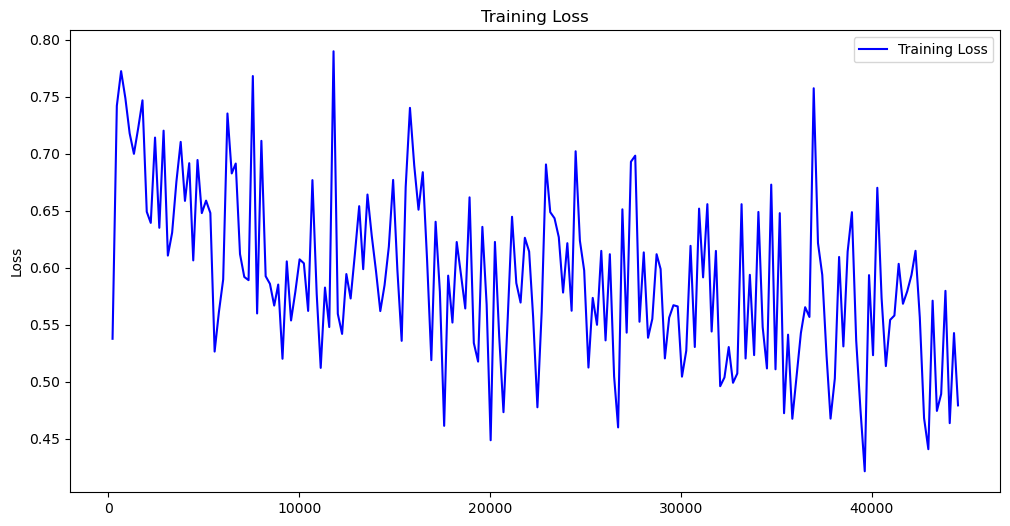

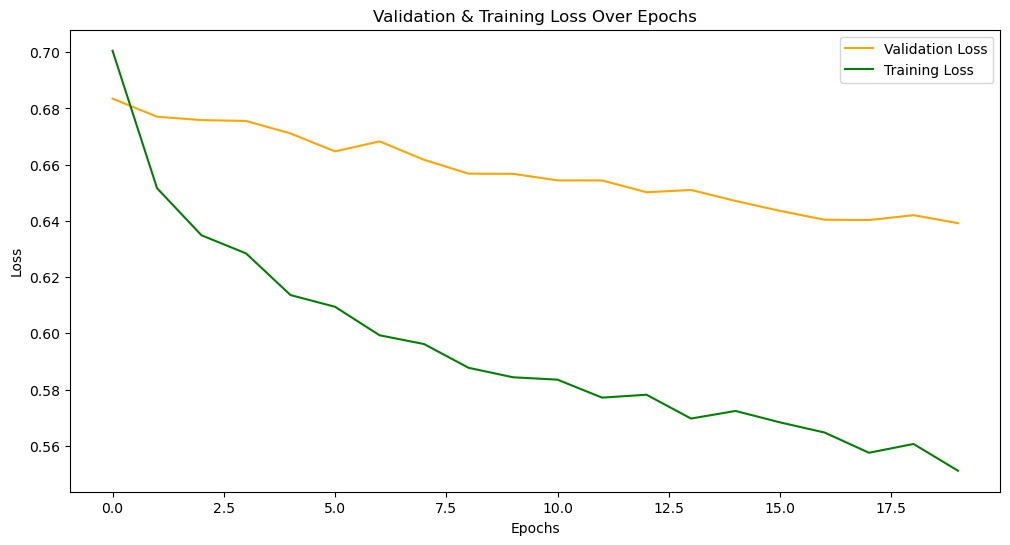

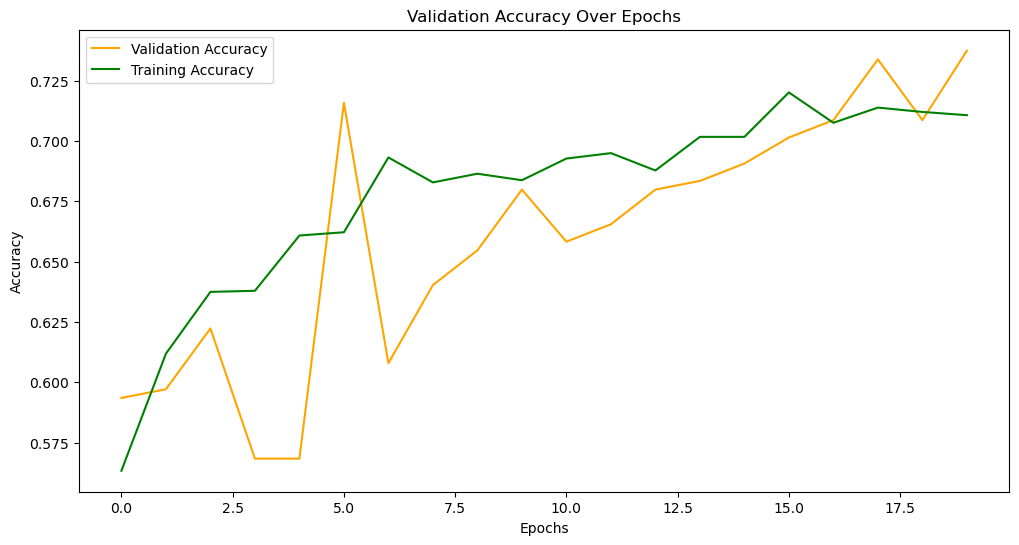

In [84]:
# Plot results
# epoch counter 
plt.figure(figsize=(12, 6))
plt.plot(log_counter, log_losses, color='blue', label='Training Loss')
plt.legend()
plt.title("Training Loss"); plt.ylabel('Loss')

plt.figure(figsize=(12, 6))
plt.plot(range(len(val_losses)), val_losses, color='orange', label='Validation Loss')
plt.plot(range(len(train_losses)), train_losses, color='green', label='Training Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title("Validation & Training Loss Over Epochs")
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(range(len(val_accuracies)), val_accuracies, color='orange', label='Validation Accuracy')
plt.plot(range(len(train_accuracies)), train_accuracies, color='green', label='Training Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title("Validation Accuracy Over Epochs")
plt.legend()

plt.show()

In [92]:
import time

start_time = time.time()

# Load the best model before testing
model.load_state_dict(torch.load("best_model_AE.pth", weights_only = True))
test_loss, test_accuracy, test_pred, test_labels = evaluate(test_loader, model, DEVICE, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

end_time = time.time()

elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"Total training time: {int(minutes)} minutes and {int(seconds)} seconds")


Test Loss: 0.6326, Test Accuracy: 0.7464


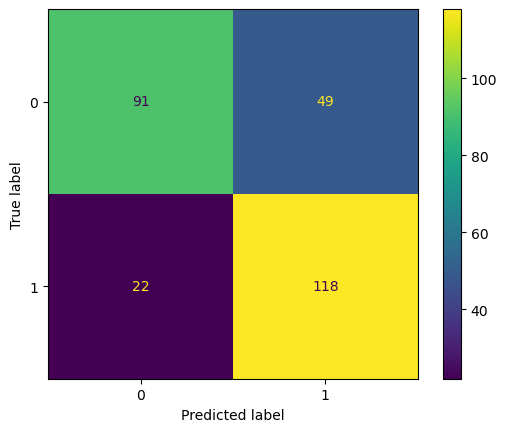

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)